# **HATE SPEECH DETECTION USING LSTM AND BILSMT ON DAVIDSON**

**REFERENCE**: The implementation here is a combination of different implementations: <br>
[1] Pinkesh Badjatiya and Shashank Gupta in "Deep Learning for Hate Speech Detection" (to appear in WWW'17 proceedings) (2017) at https://github.com/pinkeshbadjatiya/twitter-hatespeech <br>
[2] Adil Emre Bilgic(June, 2021) in "Sentiment Analysis Hate Speech at https://www.kaggle.com/adilemrebilgic/sentiment-analysis-hate-speech/notebook<br>
[3] Srishti Bhalla(Feb 2019) in Hate-Speech-Detection-on-Twitter-Data at https://github.com/srishb28/Hate-Speech-Detection-on-Twitter-Data trained on the dataset of Zeerak et. al. at https://github.com/ZeerakW/hatespeech mentioned also in the report<br>
[4] Deephate: Paper: Cao, R., Ka-Wei Lee, R., Hoang, T.A.: DeepHate: Hate Speech Detection via Multi-Faceted Text Representations. In: WebSci ’20: 12th ACM Conference on Web Science, July 2020 Pages 11–20 (October 2020) https://gitlab.com/bottle_shop/safe/deephate/-/tree/master/DeepHate<br><br>

In this notebook we present the approach as we are trying to detect hate speech in tweets of the Davidson dataset. The dataset is distributed as hate, offensive and neither. The label '1' denotes the tweet is offensive and label '0' is hate, label `2` is neither.

There are two models: LSTM and BiLSTM. We train the models on Davidson dataset, where we split on **80%** for training and **20%** on testing. The data is not shuffled in order to have a fair comparison between other models presented in the paper i.e Deephate and TFIDF Based Model.

> There is a simple LSTM network tested with different hidden units (**50, 64, 128** unit in the hidden layer) and a drop out rate of `0.2` and a reccurrent droput rate of `0.4`. There is one dense layer at the end with 1 unit and an activation function as sigmoid (since we are trying to predict different classes labels `0`, `1`, and `2`). We use `categorical_cross_entropy` loss as well.

The models are fine tunded by differing the no.of.epochs 1-100 epochs and batch size (32,64,128, 256).You can have a look at the accuracy and training plot below, with respective comments.
<br><br><br>
**Table of Contents:**<br><br>

---
HATE SPEECH DETECTION USING LSTM AND BILSMT ON KAGGLE
1. Imports and Preleminaries
2. Data Cleaning
 - Text Pre-Processing
 - Cleaning Pipeline
 - Data Preparation
3. LSTM and BiLSTM Models
4. Training
5. Model Training
 - Word Embeddings
    - Train The Word2Vec Embedding on Davidson tweets
    - Use Embedding Layer as trainable layer for LSTM and BiLSTM
    - Use Embedding Layer as non-trainable for LSTM and BiLSTM
6. Controversial Topic Analysis
<br><br><br>
How to run the notebook?

---


1.   Start the notebook and run every cell
2.   Make sure to have all packages installed. It might be better if you use Google Colab or Kaggle as they already have most of the packages available for usage
3.   Packages to be installed: Numpy, Pandas, Matplotlib, Seaborn, Tensorflow, nltk, keras, and genism
4.   Then you can just run the notebook as usuall and enjoy the result :)
5.   If anything happens please contact as to our email address as noted on the submission lab report.
---

<br>
Thank you for your understanding!



## Import and Preleminaries

In [ ]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
import keras.utils
from keras.utils.np_utils import to_categorical
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import LeakyReLU
from keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Loading Data

Lets load the data to content folder in github. The data will be loadet to `\content\name_of_file`

In [ ]:
# Use this only if you are using colab otherwise comment it out
from google.colab import files
dataset_file_dict = files.upload()

Saving 150labeledLGBT.csv to 150labeledLGBT.csv
Saving 190labeledTrump.csv to 190labeledTrump.csv
Saving 190labeledCovid.csv to 190labeledCovid.csv
Saving davidson.csv to davidson.csv


This are the dataset that are used for controversial topic analysis. Make sure the content path is correct in your system. In colab the files would be uploaded to /content directory. This would be used in the end of the notebook to analyse the result based on the model training. We would use LSTM for testing


In [ ]:
df_trump = pd.read_csv("/content/190labeledTrump.csv")
df_lgbt = pd.read_csv("/content/150labeledLGBT.csv")
df_covid = pd.read_csv("/content/190labeledCovid.csv")

In [ ]:
davidson_df = pd.read_csv("/content/davidson.csv")
print(davidson_df.head())
print(len(davidson_df))
classes = davidson_df.groupby('class')
print(classes.describe())

# df_temp = davidson_df[['class', 'tweet']]
# test_data = df_temp[19827:].copy() # 4956 will be test data so we can compare with deep hate and tfidf
# data = df_temp[:19827].copy()
# print(data)

   Unnamed: 0  count  ...  class                                              tweet
0           0      3  ...      2  !!! RT @mayasolovely: As a woman you shouldn't...
1           1      3  ...      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2           2      3  ...      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3           3      3  ...      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4           4      6  ...      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

[5 rows x 7 columns]
24783
      Unnamed: 0                                   ... neither               
           count          mean          std   min  ...     25%  50%  75%  max
class                                              ...                       
0         1430.0  10983.741958  7241.005639  85.0  ...     0.0  0.0  0.0  4.0
1        19190.0  12827.344919  7304.666765   1.0  ...     0.0  0.0  0.0  3.0
2         4163.0  12590.555369  7222.217918   0.0  ...     2.0  3.0  3.0  9.0


## Data Preprocessing

In [ ]:
davidson_df.isnull().values.any()

False

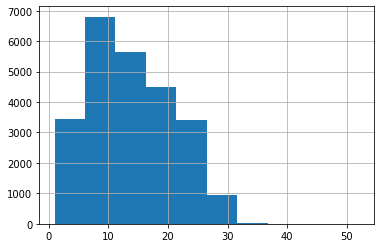

In [ ]:
davidson_df['tweet'].str.split().map(lambda x: len(x)).hist()

### Text Pre-Processing

This is rather a simple cleaning pipeline:


1.   Remove special characters and leave only letters.
2.   Lowercase all letters and split the text
3.   Remove emojis/links/usernames and normalize hash tags.
4.   Apply stemming on the data to fix the influence of the bad words
5.   Remove all the stopwords as they are do not contain a lot of information stored.
6.   Create a sequence again

> This method was part of the Deephate project found in the submission folder in gitlab. We tried to align our methods in order to have a much more fair comparison. However, in LSTM we also make use of Stemming as we believe this might be a factor that influence the learning of the model

### Cleaning Pipleine
The cleaning is similar to deephate.
Reference: Code implementation for the paper "DeepHate: Hate Speech Detection via Multi-Faceted Text Representations" (WebSci'20) Roy Lee (2021) at https://gitlab.com/bottle_shop/safe/deephate/-/blob/master/DeepHate/dataset.py

In [ ]:
def expand_match(contraction):
    contraction_mapping = {
        "isn't": "is not",
        "aren't": "are not",
        "con't": "cannot",
        "can't've": "cannot have",
        "you'll've": "your will have",
        "you're": "you are",
        "you've": "you have"
    }
    match = contraction.group(0)
    first_char = match[0]
    expanded_contraction = contraction_mapping.get(match) \
        if contraction_mapping.get(match) \
        else contraction_mapping.get(match.lower())
    expanded_contraction = first_char + expanded_contraction[1:]
    return expanded_contraction

In [ ]:
def clean_tweets(text):
    url_pattern = re.compile(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')
    emojis_pattern = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    hash_pattern = re.compile(r'#\w*')
    single_letter_pattern = re.compile(r'(?<![\w\-])\w(?![\w\-])')
    blank_spaces_pattern = re.compile(r'\s{2,}|\t')
    reserved_pattern = re.compile(r'(RT|rt|FAV|fav|VIA|via)')
    mention_pattern = re.compile(r'@\w*')
    CONTRACTION_MAP = {
        "isn't": "is not",
        "aren't": "are not",
        "con't": "cannot",
        "can't've": "cannot have",
        "you'll've": "your will have",
        "you're": "you are",
        "you've": "you have"
    }
    constraction_pattern = re.compile('({})'.format('|'.join(CONTRACTION_MAP.keys())),
                                        flags=re.IGNORECASE | re.DOTALL)
    Whitespace = re.compile(u"[\s\u0020\u00a0\u1680\u180e\u202f\u205f\u3000\u2000-\u200a]+", re.UNICODE)
    urls = re.sub(pattern=url_pattern, repl='', string=text)
    mentions = re.sub(pattern=mention_pattern, repl='', string=urls)
    hashtag = re.sub(pattern=hash_pattern, repl='', string=mentions)
    reserved = re.sub(pattern=reserved_pattern, repl='', string=hashtag)
    reserved = Whitespace.sub(" ", reserved)
    reserved = constraction_pattern.sub(expand_match, reserved)
    punct = "[{}]+".format(string.punctuation)
    punctuation = re.sub(punct, '', reserved)
    single = re.sub(pattern=single_letter_pattern, repl='', string=punctuation)
    blank = re.sub(pattern=blank_spaces_pattern, repl=' ', string=single)
    blank = blank.lower()
    # print blank
    return blank.split()

In [ ]:
def tweet_processing(raw_tweet):
    words = clean_tweets(raw_tweet)
    stops = set(stopwords.words("english"))
    m_w = [w for w in words if not w in stops]
    return (" ".join(m_w))

In [ ]:
def process_df_tweet(data_df):
    topic_data = data_df[~data_df['combined_label'].isnull()][['tweets', 'combined_label']] # label2, label3
    num_tweets = topic_data["tweets"].size
    clean_tweet = []
    for i in range(0,num_tweets):
        clean_tweet.append(tweet_processing(topic_data["tweets"][i]))
    topic_data["tweet"] = clean_tweet
    topic_data["class"] = topic_data["combined_label"]
    topic_data["class"] = topic_data["class"].astype(int)
    return topic_data

In [ ]:
# Clean tweets
num_tweets = davidson_df["tweet"].size
clean_tweet = []
for i in range(0,num_tweets):
    clean_tweet.append(tweet_processing(davidson_df["tweet"][i]))
davidson_df["tweet"] = clean_tweet

# num_tweets_test = test_data["tweet"].size
# clean_tweet_test = []
# for i in range(num_tweets, num_tweets + num_tweets_test):
#     clean_tweet_test.append(tweet_processing(test_data["tweet"][i]))
# test_data["tweet"]=clean_tweet_test

In [ ]:
trump_data = process_df_tweet(df_trump)
# df_lgbt['combined_label'] = df_lgbt['combined_labels']
lgbt_data = process_df_tweet(df_lgbt)
covid_data = process_df_tweet(df_covid)

## Deep Learning Models

Let's make the data ready for training. We need to:

- tokenize the sequence in words and assign each word in the vocabulary an index so we can relate it later on.
- pad the vectorized sequence to have fixed unit
- split the dataset into 80\% training and 20% testing without shuffling in order to have a better comparison between the models of other collegues (i.e TFIDF and Deephate)

In [ ]:
def process_data(data, max_len=50):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data['tokenized_sents'])
    sequences = tokenizer.texts_to_sequences(data['tokenized_sents'])
    # Pad the sequence in order to have max length...
    x = pad_sequences(sequences, maxlen=max_len)
    # Make one hot encoding for labeling part. Should be in input [1 0]
    # It is similar to doing sth like that:
    # data['hate_speech']=0
    # data['offensive_language']=0
    # data['neither']=0
    # data['hate_speech'] = np.where(data['class'] == 0, 1, 0)
    # data['offensive_language'] = np.where(data['class'] == 1, 1, 0)
    # data['neither'] = np.where(data['class'] == 2, 1, 0)
    # columns=['hate_speech','offensive_language','neither']
    # y=data[columns].values
    y = to_categorical(data['class'], num_classes=3)
    # splitting the Dataset into Train and Test set
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=0, shuffle=False)
    return x_train, x_test, y_train, y_test

Tokenize the dataset and use this one to train the Word 2 vec model

In [ ]:
def tokenize_pad_sequence(data, max_len=50):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data['tokenized_sents'])
    sequences = tokenizer.texts_to_sequences(data['tokenized_sents'])
    return pad_sequences(sequences, maxlen=max_len)

In [ ]:
davidson_df['tokenized_sents'] = davidson_df.apply(lambda column: word_tokenize(column['tweet']), axis=1)

In [ ]:
trump_data['tokenized_sents'] = trump_data.apply(lambda column: word_tokenize(column['tweet']), axis=1)
lgbt_data['tokenized_sents'] = lgbt_data.apply(lambda column: word_tokenize(column['tweet']), axis=1)
covid_data['tokenized_sents'] = covid_data.apply(lambda column: word_tokenize(column['tweet']), axis=1)

Tokenize the sequence and then we pad. Acccording to the length distribution the max number of tweets was around 30-40. Hence we set it 50 during training to accound for any edge cases.

In [ ]:
x_train, x_test, y_train, y_test = process_data(davidson_df)

In [ ]:
trump_test = tokenize_pad_sequence(trump_data)
lgbt_test = tokenize_pad_sequence(lgbt_data)
covid_test = tokenize_pad_sequence(covid_data)

### Word Embeddings

In KAGGLE Notebook we also made experiments with Embeddings. Here we will directly use word embeddings from Word2Vec model as this model will also be used to label controversial topics. We believe that embeddings provide more insights to the data than an actual normal one-hot encoding.

In our experiments we will use WordEmbeddings to train the LSTM and BiLSTM model. To train a word2vec model.

In [ ]:
from gensim.models import Word2Vec

# define training data from the davidson (data must be tokenized)
sentences = davidson_df['tokenized_sents']
# train model on davdsion dataset
model = Word2Vec(sentences, size=200, window =4, min_count=1, sg=1)
words = list(model.wv.vocab)

# Store the model somewhere so you don't have to train it every time,
# although for davidson dataset it does not take long to train
model.save('davidson_Word2Vec.bin')

# In case we have a pretrained model we can also use that to get word embeddings
# And you can simply load like this. Uncomment the line if needed
# model = Word2Vec.load('davidson_Word2Vec.bin')

Compare the words with other words in the dataset. For comparison cosine similarity is used between words vector representation.

In [ ]:
# model.most_similar('lmao')

Now it is time to create an embedding matrix based on the word embeddings we have.

In [ ]:
# Reference: https://github.com/pinkeshbadjatiya/twitter-hatespeech
from string import punctuation
from collections import defaultdict
def get_vocab(data):
    # Processing
    vocab, reverse_vocab = {}, {}
    freq = defaultdict(int)
    vocab_index = 1
    for text in data:
        for word in text:
            if word not in vocab:
                vocab[word] = vocab_index
                reverse_vocab[vocab_index] = word       # generate reverse vocab as well
                vocab_index += 1
            freq[word] += 1
    vocab['UNK'] = len(vocab) + 1
    reverse_vocab[len(vocab)] = 'UNK'
    return vocab, reverse_vocab, freq

In [ ]:
vocabulary, reverse_vocabulary, frequencies = get_vocab(davidson_df['tokenized_sents'])

In [ ]:
vocab_size = len(vocabulary)
print(vocab_size)
embedding_matrix = np.zeros((vocab_size,200))

for i in range(0,len(words)):
    embedding_vector = model.wv[words[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix[vocab_size-1]= np.random.normal(scale=0.6, size=(200, ))

20675


Let's define our models and later to train them

Since davidson has 3 main classes we will use a softmax activation fucntion.
Then a dense layer with 3 units is defined. The model prodcues probabilistic values and later we can compare to define what is the class that is being outputed based on a threshold value e.g 0.5 or so

Categorical cross entropy loss accounts for different classes and is used instead of binary cross entropy since there are multiple labels being classified.

In [ ]:
def get_lstm(vocab_size, embedding_matrix, input_size=50, embedding_size=200, trainable=True, hidden_unit=50):
    # For davidson dataset I tried another approach.
    # You can set trainable to False in order not to train embedding layer
    inp = Input(shape=(input_size,))
    if trainable is True:
        x = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=True)(inp)
    else:
        x = Embedding(vocab_size,200,weights=[embedding_matrix], trainable=False)(inp)
    x = (LSTM(hidden_unit, return_sequences=True, dropout=0.2, recurrent_dropout=0.4))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50)(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = Dropout(0.2)(x)
    x = Dense(3, activation='softmax')(x)
    x = LeakyReLU(alpha=0.02)(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def get_bilstm(vocab_size, embedding_matrix, input_size=50, embedding_size=200, trainable=True, hidden_unit=50):
    # For davidson dataset I tried another approach.
    inp_bi = Input(shape=(input_size,))
    if trainable is True:
        x_bi = Embedding(vocab_size,embedding_size,weights=[embedding_matrix], trainable=True)(inp_bi)
    else:
        x_bi = Embedding(vocab_size,200,weights=[embedding_matrix], trainable=False)(inp_bi)
    x_bi = Bidirectional(LSTM(hidden_unit, return_sequences=True, dropout=0.2, recurrent_dropout=0.4))(x_bi)
    x_bi = GlobalMaxPool1D()(x_bi)
    x_bi = Dense(50)(x_bi)
    x_bi=LeakyReLU(alpha=0.02)(x_bi)
    x_bi = Dropout(0.2)(x_bi)
    x_bi = Dense(3, activation='softmax')(x_bi)
    # x_bi=LeakyReLU(alpha=0.02)(x_bi)
    model_bi = Model(inputs=inp_bi, outputs=x_bi)
    model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_bi.summary()
    return model_bi

Now we can define our training pipeline

In [ ]:
from sklearn.utils import class_weight
def train_model(model, x_train, y_train, x_test, y_test, x_val=None, y_val=None, set_batch_size=64, num_epochs=10, scale_loss=False, early_stopping=True):
    # Stop if the model overfits...
    if early_stopping is True:
        stop = EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=5
        )
    # Save model logs during training to the specific folder
    checkpoint= ModelCheckpoint(
        filepath='./',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
    # Lets specify some weights for our class function
    # since the dataset is not really balanced and may cause overfitting
    class_weights = None
    if scale_loss is True:
        class_weights = {}
        class_weights[0] = np.where(y_train == 0)[0].shape[0]/float(len(y_train))
        class_weights[1] = np.where(y_train == 1)[0].shape[0]/float(len(y_train))
        class_weights[2] = np.where(y_train == 2)[0].shape[0]/float(len(y_train))
    callback = []
    if early_stopping is True:
        callback = [stop, checkpoint]
    else:
        callaback = [checkpoint]
    # training the model
    history = model.fit(x_train,
                        y_train,
                        class_weight=class_weights,
                        validation_split=0.2,
                        epochs=num_epochs,
                        batch_size=set_batch_size,
                        callbacks=callback)
    # Visualizing training accuracy and loss per epoch to eliminate the potential threat of overfitting
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(history.history['accuracy'])), history.history['accuracy'], 'b', label='training acc')
    plt.plot(np.arange(len(history.history['accuracy'])), history.history['val_accuracy'], 'c', label='val acc')
    plt.title('Accuracy Plot')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(history.history['accuracy'])), history.history['loss'], 'r', label='training loss')
    plt.plot(np.arange(len(history.history['accuracy'])), history.history['val_loss'], 'g', label='val loss')
    plt.legend(loc='best')
    plt.title('Loss Plot')
    plt.ylabel('Error/Loss')
    plt.xlabel('Epochs')
    plt.show()
    # Evaluate the model on the test set and check the accuracy
    evaluation = model.evaluate(x_test, y_test)
    # predicting and getting accuracy
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    # y_pred = [1 if prob==True else 0 for prob in y_pred]
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    precision_bi, recall_bi, fscore_bi, support_bi = precision_recall_fscore_support(np.argmax(y_test, axis=1), y_pred)
    print('\nAccuracy', accuracy_score(np.argmax(y_test, axis=1),y_pred))
    print('LSTM: non hate - hate')
    print('precision: {}'.format(precision_bi))
    print('recall: {}'.format(recall_bi))
    print('fscore: {}'.format(fscore_bi))
    print('support: {}'.format(support_bi))
    # getting confusion matrix
    print('\nConfusion Matrix: \n', confusion_matrix(np.argmax(y_test, axis=1), y_pred))
    return model

#### Training Results and some experiments
> Disclaimer: Notice that the results can change due to different number of parameter thay you may use. We have used different batch sizes and different epoch counts. Here are just samples from the training

In [ ]:
lstm_model = get_lstm(vocab_size, embedding_matrix=embedding_matrix, input_size=x_train.shape[1])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 50, 200)           4135000   
                                                                 
 lstm_3 (LSTM)               (None, 50, 50)            50200     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 50)                0         
                                                           

Epoch 1/6
62/62 [==============================] - 29s 416ms/step - loss: 0.7208 - accuracy: 0.7576 - val_loss: 0.6409 - val_accuracy: 0.7857
Epoch 2/6
62/62 [==============================] - 25s 397ms/step - loss: 0.6710 - accuracy: 0.7656 - val_loss: 0.5164 - val_accuracy: 0.8379
Epoch 3/6
62/62 [==============================] - 25s 401ms/step - loss: 0.4674 - accuracy: 0.8445 - val_loss: 0.3096 - val_accuracy: 0.9037
Epoch 4/6
62/62 [==============================] - 24s 394ms/step - loss: 0.3104 - accuracy: 0.8968 - val_loss: 0.2923 - val_accuracy: 0.9087
Epoch 5/6
62/62 [==============================] - 25s 402ms/step - loss: 0.2507 - accuracy: 0.9144 - val_loss: 0.3157 - val_accuracy: 0.9057
Epoch 6/6
62/62 [==============================] - 24s 393ms/step - loss: 0.2112 - accuracy: 0.9258 - val_loss: 0.3472 - val_accuracy: 0.8956


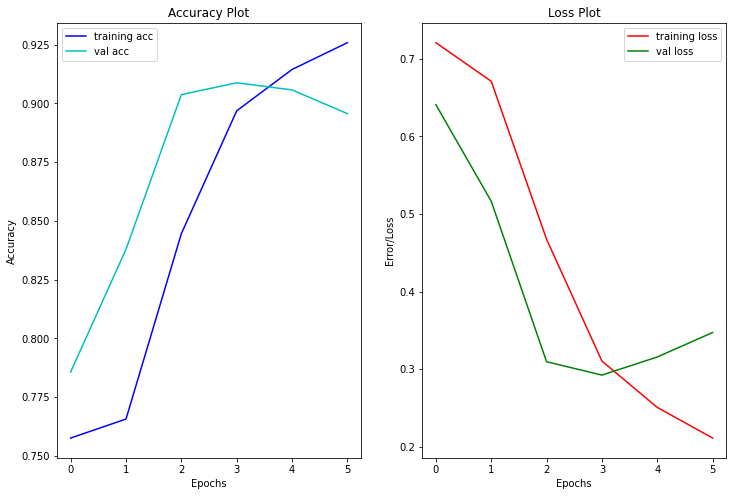

155/155 [==============================] - 2s 15ms/step - loss: 0.3805 - accuracy: 0.8796
              precision    recall  f1-score   support

           0       0.15      0.11      0.12       234
           1       0.93      0.95      0.94      3928
           2       0.79      0.75      0.77       795

    accuracy                           0.88      4957
   macro avg       0.62      0.60      0.61      4957
weighted avg       0.87      0.88      0.87      4957


Accuracy 0.8795642525721202
LSTM: non hate - hate
precision: [0.14792899 0.9271556  0.78856383]
recall: [0.10683761 0.95264766 0.74591195]
fscore: [0.12406948 0.93972878 0.76664512]
support: [ 234 3928  795]

Confusion Matrix: 
 [[  25  168   41]
 [  68 3742  118]
 [  76  126  593]]


In [ ]:
lstm_model_trained = train_model(lstm_model,
                                 x_train,
                                 y_train,
                                 x_test,
                                 y_test,
                                 set_batch_size=256,
                                 scale_loss=False,
                                 num_epochs=6)
#saving model
lstm_model_trained.save('model_lstm.h5')

In [ ]:
# vocab_size = lunique words in the corpus genrated from word2vec genism
lstm_embedding_model = get_lstm(vocab_size, embedding_matrix=embedding_matrix, input_size=x_train.shape[1], trainable=False)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 200)           4135000   
                                                                 
 lstm (LSTM)                 (None, 50, 50)            50200     
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50)                0         
                                                             

Epoch 1/100
496/496 [==============================] - 45s 85ms/step - loss: 0.6853 - accuracy: 0.7653 - val_loss: 0.5953 - val_accuracy: 0.7920
Epoch 2/100
496/496 [==============================] - 43s 87ms/step - loss: 0.6710 - accuracy: 0.7686 - val_loss: 0.5913 - val_accuracy: 0.7950
Epoch 3/100
496/496 [==============================] - 41s 82ms/step - loss: 0.6687 - accuracy: 0.7672 - val_loss: 0.5861 - val_accuracy: 0.7955
Epoch 4/100
496/496 [==============================] - 41s 82ms/step - loss: 0.6659 - accuracy: 0.7686 - val_loss: 0.5988 - val_accuracy: 0.7965
Epoch 5/100
496/496 [==============================] - 41s 83ms/step - loss: 0.6638 - accuracy: 0.7697 - val_loss: 0.5933 - val_accuracy: 0.7882
Epoch 6/100
496/496 [==============================] - 41s 83ms/step - loss: 0.6644 - accuracy: 0.7703 - val_loss: 0.5856 - val_accuracy: 0.7932
Epoch 7/100
496/496 [==============================] - 41s 82ms/step - loss: 0.6631 - accuracy: 0.7705 - val_loss: 0.5767 - val_ac

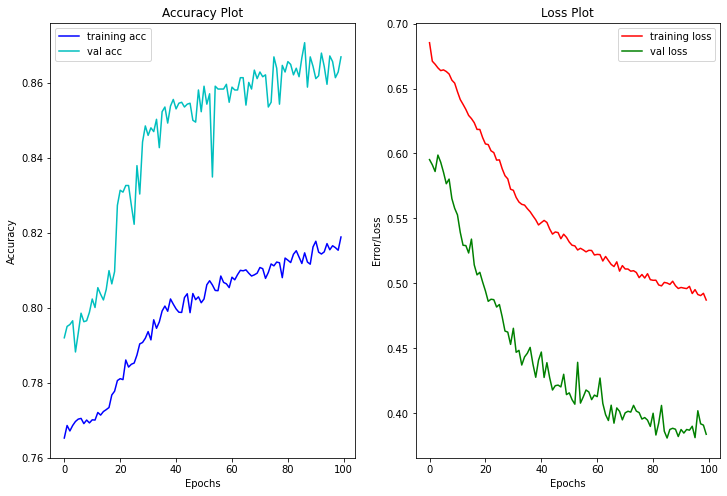

155/155 [==============================] - 3s 16ms/step - loss: 0.4330 - accuracy: 0.8396
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.89      0.93      0.91      3928
           2       0.60      0.63      0.61       795

    accuracy                           0.84      4957
   macro avg       0.50      0.52      0.51      4957
weighted avg       0.80      0.84      0.82      4957


Accuracy 0.8396207383498083
LSTM: non hate - hate
precision: [0.         0.88735465 0.602657  ]
recall: [0.         0.93253564 0.62767296]
fscore: [0.         0.90938431 0.61491066]
support: [ 234 3928  795]

Confusion Matrix: 
 [[   0  169   65]
 [   1 3663  264]
 [   0  296  499]]


In [ ]:
lstm_model_embbedding_trained = train_model(lstm_embedding_model,
                                 x_train,
                                 y_train,
                                 x_test,
                                 y_test,
                                 set_batch_size=32,
                                 scale_loss=False,
                                 num_epochs=100,
                                 early_stopping=False)

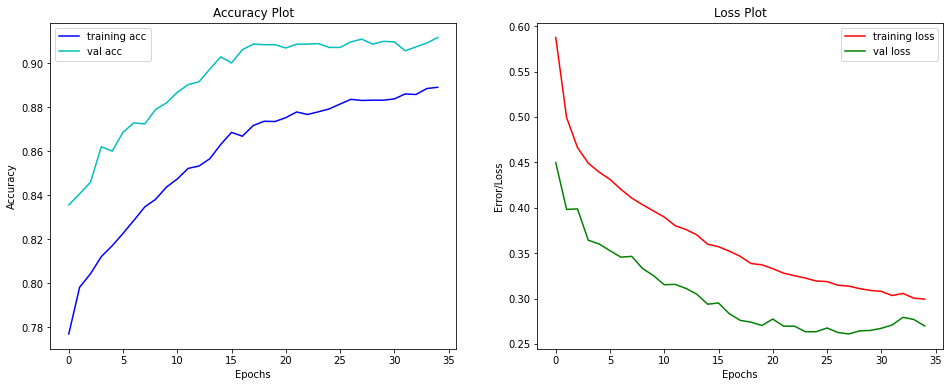

In [ ]:
# This is an old run of the method training LSTM without training embedding layer.
# It achieved around 90% accuracy and the training has a tendency to go down.

__Training a BiLSTM model__

In [ ]:
# vocab_size = lunique words in the corpus genrated from word2vec genism
bilstm_model = get_bilstm(vocab_size, embedding_matrix=embedding_matrix, input_size=x_train.shape[1])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 200)           4135000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 100)          100400    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 50)                0   

Epoch 1/6
63/63 [==============================] - 55s 757ms/step - loss: 0.7009 - accuracy: 0.7641 - val_loss: 0.5935 - val_accuracy: 0.7857
Epoch 2/6
63/63 [==============================] - 48s 755ms/step - loss: 0.5101 - accuracy: 0.8164 - val_loss: 0.3394 - val_accuracy: 0.9085
Epoch 3/6
63/63 [==============================] - 48s 767ms/step - loss: 0.3620 - accuracy: 0.8830 - val_loss: 0.3042 - val_accuracy: 0.9027
Epoch 4/6
63/63 [==============================] - 48s 756ms/step - loss: 0.2952 - accuracy: 0.9011 - val_loss: 0.2784 - val_accuracy: 0.9097
Epoch 5/6
63/63 [==============================] - 47s 742ms/step - loss: 0.2471 - accuracy: 0.9177 - val_loss: 0.2722 - val_accuracy: 0.9105
Epoch 6/6
63/63 [==============================] - 47s 743ms/step - loss: 0.1702 - accuracy: 0.9421 - val_loss: 0.2849 - val_accuracy: 0.9105


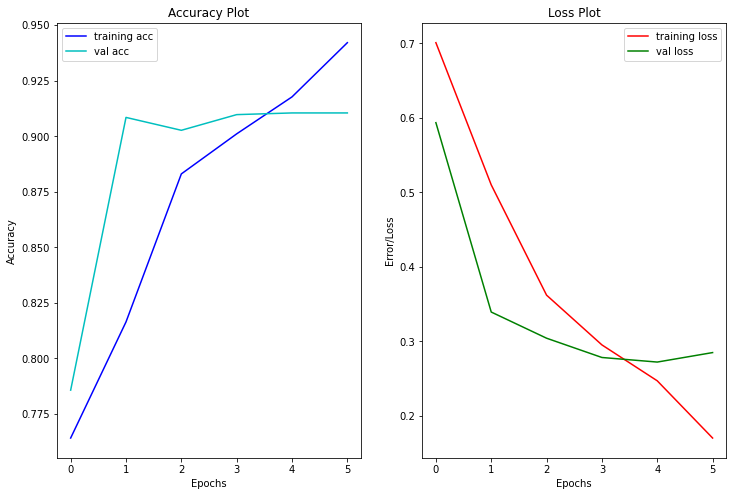

155/155 [==============================] - 4s 27ms/step - loss: 0.3373 - accuracy: 0.8925
              precision    recall  f1-score   support

           0       0.37      0.23      0.28       234
           1       0.94      0.94      0.94      3928
           2       0.77      0.84      0.81       795

    accuracy                           0.89      4957
   macro avg       0.69      0.67      0.68      4957
weighted avg       0.88      0.89      0.89      4957


Accuracy 0.8924752874722615
LSTM: non hate - hate
precision: [0.36551724 0.93746835 0.774942  ]
recall: [0.22649573 0.94271894 0.84025157]
fscore: [0.27968338 0.94008632 0.8062764 ]
support: [ 234 3928  795]

Confusion Matrix: 
 [[  53  135   46]
 [  77 3703  148]
 [  15  112  668]]


In [ ]:
bilstm_model_trained = train_model(bilstm_model,
                                 x_train,
                                 y_train,
                                 x_test,
                                 y_test,
                                 set_batch_size=254,
                                 scale_loss=False,
                                 num_epochs=6,
                                 early_stopping=True)

In [ ]:
# bilstm_model_trained.save('model_bilstm.h5')

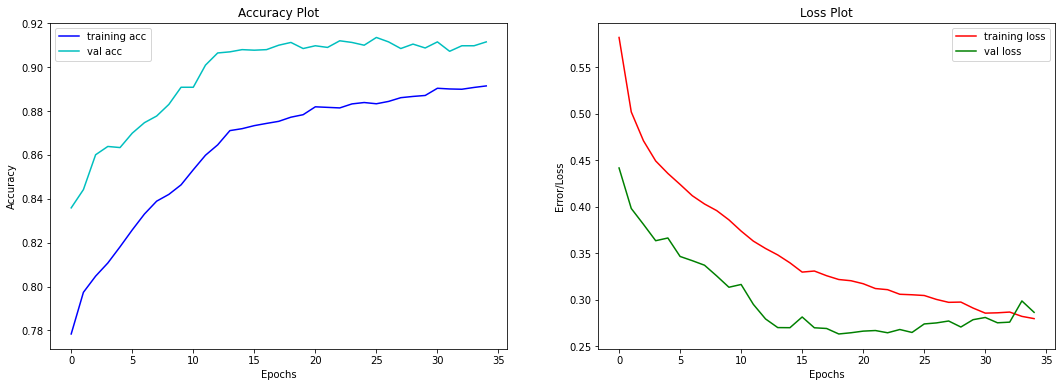

In [ ]:
# This is an old run of the method training BiLSTM without training embedding layer.
# It achieved around 90% accuracy and the training has a tendency to go down.

Let's also test the bilstm without changing the embedding weights for davidson

In [ ]:
# vocab_size = lunique words in the corpus genrated from word2vec genism
bilstm_model_embeddings = get_bilstm(vocab_size, embedding_matrix=embedding_matrix, input_size=x_train.shape[1], trainable=False)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 50, 200)           4135000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 100)          100400    
 nal)                                                            
                                                                 
 global_max_pooling1d_4 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 50)                0   

Epoch 1/100
62/62 [==============================] - 40s 648ms/step - loss: 0.6618 - accuracy: 0.7689 - val_loss: 0.5894 - val_accuracy: 0.7945
Epoch 2/100
62/62 [==============================] - 40s 641ms/step - loss: 0.6609 - accuracy: 0.7701 - val_loss: 0.5894 - val_accuracy: 0.7978
Epoch 3/100
62/62 [==============================] - 40s 647ms/step - loss: 0.6591 - accuracy: 0.7710 - val_loss: 0.5853 - val_accuracy: 0.7945
Epoch 4/100
62/62 [==============================] - 40s 648ms/step - loss: 0.6576 - accuracy: 0.7709 - val_loss: 0.5876 - val_accuracy: 0.7970
Epoch 5/100
62/62 [==============================] - 40s 638ms/step - loss: 0.6536 - accuracy: 0.7710 - val_loss: 0.5717 - val_accuracy: 0.7968
Epoch 6/100
62/62 [==============================] - 40s 648ms/step - loss: 0.6492 - accuracy: 0.7726 - val_loss: 0.5612 - val_accuracy: 0.7995
Epoch 7/100
62/62 [==============================] - 40s 641ms/step - loss: 0.6454 - accuracy: 0.7707 - val_loss: 0.5755 - val_accuracy:

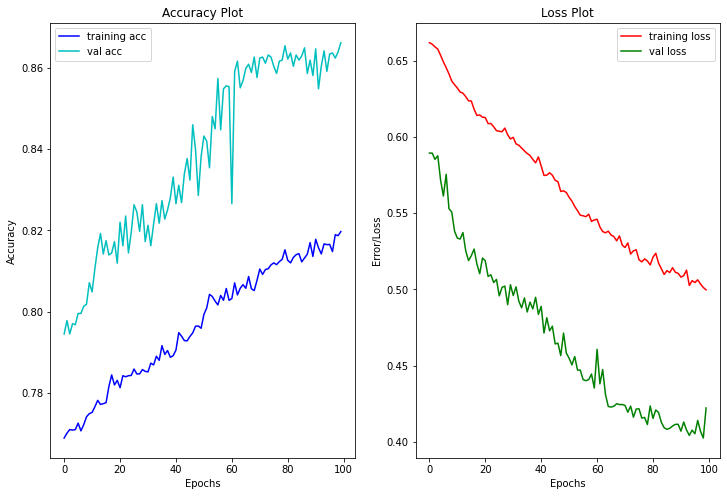

155/155 [==============================] - 4s 28ms/step - loss: 0.4684 - accuracy: 0.8422
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.88      0.94      0.91      3928
           2       0.63      0.59      0.61       795

    accuracy                           0.84      4957
   macro avg       0.50      0.51      0.51      4957
weighted avg       0.80      0.84      0.82      4957


Accuracy 0.8422432923138995
LSTM: non hate - hate
precision: [0.         0.87936357 0.63270777]
recall: [0.         0.94271894 0.59371069]
fscore: [0.         0.9099398  0.61258923]
support: [ 234 3928  795]

Confusion Matrix: 
 [[   0  185   49]
 [   0 3703  225]
 [   0  323  472]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
bilstm_model_embedding_trained = train_model(bilstm_model_embeddings,
                                 x_train,
                                 y_train,
                                 x_test,
                                 y_test,
                                 set_batch_size=256,
                                 scale_loss=False,
                                 num_epochs=100,
                                 early_stopping=False)

### Testing and Controversial Topic Analysis

Lets see how the models work in practice. We will test them with our test set. And check the values below.

### Evaluation Results on the dataset

In [ ]:
predicted_lstm = lstm_model_trained.predict(x_test)
predicted_lstm_embeddings = lstm_model_embbedding_trained.predict(x_test)
predicted_bi = bilstm_model_trained.predict(x_test)
predicted_bi_embeddings = bilstm_model_embedding_trained.predict(x_test)

In [ ]:
dataframe_lstm = pd.DataFrame.from_records(predicted_lstm)
dataframe_lstm_embeddings = pd.DataFrame.from_records(predicted_lstm_embeddings)
dataframe_bi = pd.DataFrame.from_records(predicted_bi)
dataframe_bi_embeddings = pd.DataFrame.from_records(predicted_bi_embeddings)

In [ ]:
dataframe_lstm.head()

,0,1,2
0,0.063121,0.014685,0.922194
1,0.011683,0.988115,0.000202
2,0.018067,0.981616,0.000317
3,0.017359,0.982161,0.000480
4,0.044635,0.009255,0.946110


Get label function creates appropriate labels according to  predictions. Predicted class is stored in a column of dataframe

In [ ]:
def get_label(df):
    if ((df[0] > df[1]) & (df[0] > df[2])):
        return 0
    elif ((df[1] > df[0]) & (df[1] > df[2])):
        return 1
    else:
        return 2

        # np.argmax(y_pred, axis=1)

dataframe_lstm['predClass'] = dataframe_lstm.apply(lambda row: get_label(row), axis=1)
dataframe_lstm_embeddings['predClass'] = dataframe_lstm_embeddings.apply(lambda row: get_label(row), axis=1)

dataframe_bi['predClass'] = dataframe_bi.apply(lambda row: get_label(row), axis=1)
dataframe_bi_embeddings['predClass'] = dataframe_bi_embeddings.apply(lambda row: get_label(row), axis=1)

__LSTM and BiLSTM score__

In [ ]:
precision_lstm, recall_lstm, fscore_lstm, support_lstm = precision_recall_fscore_support(np.argmax(y_test, axis=1), dataframe_lstm['predClass'])
print('Classes LSTM: hate - offensive - neither')
print('precision: {}'.format(precision_lstm))
print('recall: {}'.format(recall_lstm))
print('fscore: {}'.format(fscore_lstm))
print('support: {}'.format(support_lstm))
precision_bi, recall_bi, fscore_bi, support_bi = precision_recall_fscore_support(np.argmax(y_test, axis=1), dataframe_bi['predClass'])
print('Classes BILSTM: hate - offensive - neither')
print('precision: {}'.format(precision_bi))
print('recall: {}'.format(recall_bi))
print('fscore: {}'.format(fscore_bi))
print('support: {}'.format(support_bi))


print('\n\nComparison to Trained Embeddings\n\n')
precision_lstm, recall_lstm, fscore_lstm, support_lstm = precision_recall_fscore_support(np.argmax(y_test, axis=1), dataframe_lstm_embeddings['predClass'])
print('Classes Embeddings LSTM: hate - offensive - neither')
print('precision: {}'.format(precision_lstm))
print('recall: {}'.format(recall_lstm))
print('fscore: {}'.format(fscore_lstm))
print('support: {}'.format(support_lstm))
precision_bi, recall_bi, fscore_bi, support_bi = precision_recall_fscore_support(np.argmax(y_test, axis=1), dataframe_bi_embeddings['predClass'])
print('Classes Embeddings BILSTM: hate - offensive - neither')
print('precision: {}'.format(precision_bi))
print('recall: {}'.format(recall_bi))
print('fscore: {}'.format(fscore_bi))
print('support: {}'.format(support_bi))

Classes LSTM: hate - offensive - neither
precision: [0.14792899 0.9271556  0.78856383]
recall: [0.10683761 0.95264766 0.74591195]
fscore: [0.12406948 0.93972878 0.76664512]
support: [ 234 3928  795]
Classes BILSTM: hate - offensive - neither
precision: [0.36551724 0.93746835 0.774942  ]
recall: [0.22649573 0.94271894 0.84025157]
fscore: [0.27968338 0.94008632 0.8062764 ]
support: [ 234 3928  795]


Comparison to Trained Embeddings


Classes Embeddings LSTM: hate - offensive - neither
precision: [0.         0.88735465 0.602657  ]
recall: [0.         0.93253564 0.62767296]
fscore: [0.         0.90938431 0.61491066]
support: [ 234 3928  795]
Classes Embeddings BILSTM: hate - offensive - neither
precision: [0.         0.87936357 0.63270777]
recall: [0.         0.94271894 0.59371069]
fscore: [0.         0.9099398  0.61258923]
support: [ 234 3928  795]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(np.argmax(y_test, axis=1), dataframe_lstm['predClass']))
print('\nConfusion Matrix: \n', confusion_matrix(np.argmax(y_test, axis=1), dataframe_lstm['predClass']))

              precision    recall  f1-score   support

           0       0.15      0.11      0.12       234
           1       0.93      0.95      0.94      3928
           2       0.79      0.75      0.77       795

    accuracy                           0.88      4957
   macro avg       0.62      0.60      0.61      4957
weighted avg       0.87      0.88      0.87      4957


Confusion Matrix: 
 [[  25  168   41]
 [  68 3742  118]
 [  76  126  593]]


In [ ]:
print(classification_report(np.argmax(y_test, axis=1), dataframe_lstm_embeddings['predClass']))
print('\nConfusion Matrix: \n', confusion_matrix(np.argmax(y_test, axis=1), dataframe_lstm_embeddings['predClass']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.89      0.93      0.91      3928
           2       0.60      0.63      0.61       795

    accuracy                           0.84      4957
   macro avg       0.50      0.52      0.51      4957
weighted avg       0.80      0.84      0.82      4957


Confusion Matrix: 
 [[   0  169   65]
 [   1 3663  264]
 [   0  296  499]]


In [ ]:
print(classification_report(np.argmax(y_test, axis=1), dataframe_bi['predClass']))
print('\nConfusion Matrix: \n', confusion_matrix(np.argmax(y_test, axis=1), dataframe_bi['predClass']))

              precision    recall  f1-score   support

           0       0.37      0.23      0.28       234
           1       0.94      0.94      0.94      3928
           2       0.77      0.84      0.81       795

    accuracy                           0.89      4957
   macro avg       0.69      0.67      0.68      4957
weighted avg       0.88      0.89      0.89      4957


Confusion Matrix: 
 [[  53  135   46]
 [  77 3703  148]
 [  15  112  668]]


In [ ]:
print(classification_report(np.argmax(y_test, axis=1), dataframe_bi_embeddings['predClass']))
print('\nConfusion Matrix: \n', confusion_matrix(np.argmax(y_test, axis=1), dataframe_bi_embeddings['predClass']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.88      0.94      0.91      3928
           2       0.63      0.59      0.61       795

    accuracy                           0.84      4957
   macro avg       0.50      0.51      0.51      4957
weighted avg       0.80      0.84      0.82      4957


Confusion Matrix: 
 [[   0  185   49]
 [   0 3703  225]
 [   0  323  472]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Controversial Topic Analysis

We will use the following results to compare our model with Deephate based on our labeling and then to choose the best model.

In [ ]:
def analyze_controversial_topic(data, test, model_lstm, model_bilstm, title='topic'):
    predicted_lstm = model_lstm.predict(test)
    predicted_bi = model_bilstm.predict(test)
    dataframe_lstm = pd.DataFrame.from_records(predicted_lstm)
    dataframe_bi = pd.DataFrame.from_records(predicted_bi)
    dataframe_lstm['predClass'] = dataframe_lstm.apply(lambda row: get_label(row), axis=1)
    dataframe_bi['predClass'] = dataframe_bi.apply(lambda row: get_label(row), axis=1)
    print('Controversial Topic Analysis\n\n')
    print('Labels: ', title)
    print('LSTM RESULTS')
    print(classification_report(data['class'], dataframe_lstm['predClass']))
    print('\nConfusion Matrix: \n', confusion_matrix(data['class'], dataframe_lstm['predClass']))
    print('BILSTM RESULTS')
    print(classification_report(data['class'], dataframe_bi['predClass']))
    print('\nConfusion Matrix: \n', confusion_matrix(data['class'], dataframe_bi['predClass']))

### Donald Trump

In [ ]:
analyze_controversial_topic(trump_data, trump_test, model_lstm=lstm_model_trained, model_bilstm=bilstm_model_trained, title='Trump')

Controversial Topic Analysis


Labels:  Trump
LSTM RESULTS
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.28      0.93      0.43        54
           2       0.50      0.02      0.05       124

    accuracy                           0.28       189
   macro avg       0.26      0.32      0.16       189
weighted avg       0.41      0.28      0.15       189


Confusion Matrix: 
 [[  0  10   1]
 [  2  50   2]
 [  1 120   3]]
BILSTM RESULTS
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.30      1.00      0.46        54
           2       0.60      0.02      0.05       124

    accuracy                           0.30       189
   macro avg       0.30      0.34      0.17       189
weighted avg       0.48      0.30      0.16       189


Confusion Matrix: 
 [[  0   9   2]
 [  0  54   0]
 [  4 117   3]]


### LGBT

In [ ]:
analyze_controversial_topic(lgbt_data, lgbt_test, model_lstm=lstm_model_trained, model_bilstm=bilstm_model_trained, title='LGBTQ*')

Controversial Topic Analysis


Labels:  LGBTQ*
LSTM RESULTS
              precision    recall  f1-score   support

           0       0.50      0.07      0.12        14
           1       0.27      0.97      0.42        40
           2       0.33      0.01      0.02        96

    accuracy                           0.27       150
   macro avg       0.37      0.35      0.19       150
weighted avg       0.33      0.27      0.14       150


Confusion Matrix: 
 [[ 1 12  1]
 [ 0 39  1]
 [ 1 94  1]]
BILSTM RESULTS
              precision    recall  f1-score   support

           0       0.50      0.07      0.12        14
           1       0.27      0.97      0.42        40
           2       1.00      0.01      0.02        96

    accuracy                           0.27       150
   macro avg       0.59      0.35      0.19       150
weighted avg       0.76      0.27      0.14       150


Confusion Matrix: 
 [[ 1 13  0]
 [ 1 39  0]
 [ 0 95  1]]


### Covid Dataset

In [ ]:
analyze_controversial_topic(covid_data, covid_test, model_lstm=lstm_model_trained, model_bilstm=bilstm_model_trained, title='Covid19')

Controversial Topic Analysis


Labels:  Covid19
LSTM RESULTS
              precision    recall  f1-score   support

           0       0.33      0.02      0.03        57
           1       0.30      0.95      0.45        56
           2       0.38      0.04      0.07        77

    accuracy                           0.30       190
   macro avg       0.33      0.33      0.18       190
weighted avg       0.34      0.30      0.17       190


Confusion Matrix: 
 [[ 1 53  3]
 [ 1 53  2]
 [ 1 73  3]]
BILSTM RESULTS
              precision    recall  f1-score   support

           0       0.50      0.04      0.07        57
           1       0.31      0.96      0.46        56
           2       0.22      0.03      0.05        77

    accuracy                           0.31       190
   macro avg       0.34      0.34      0.19       190
weighted avg       0.33      0.31      0.18       190


Confusion Matrix: 
 [[ 2 50  5]
 [ 0 54  2]
 [ 2 73  2]]
